In [31]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from vqvae import VQVAE

In [32]:
# Define a transformation to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5, )) # maps [0,1] to [-1, 1]
])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [34]:
batch_size = 64

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [35]:
def train(model, train_loader, test_loader, optimizer, n_epochs):
    
    criterion = nn.MSELoss()
    #criterion = nn.L1Loss()
    
    train_losses = []
    
    for epoch_idx in range(n_epochs):
        
        model.train()
        model.to(device)
        
        train_losses_this_epoch = []
        
        for batch_idx, (images, _) in enumerate(tqdm(train_loader)):
            
            images = images.to(device)
            
            reconstructed, quantization_losses = model(images)
            
            loss = criterion(reconstructed, images) + quantization_losses
            
            train_losses_this_epoch.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_losses.append(np.mean(np.array(train_losses_this_epoch)))
        print(f"{epoch_idx + 1}/{n_epochs}: avg. train loss = {train_losses[-1]}")

In [36]:
n_cb_vectors = 64

vqvae = VQVAE(n_cb_vectors = n_cb_vectors, cb_dim = 16, color_channels = 1)

In [46]:
optim = torch.optim.Adam(vqvae.parameters(), lr = 3e-4)

In [47]:
train(vqvae, train_loader, test_loader, optim, n_epochs = 5)

100%|█████████████████████████████████████████| 938/938 [00:20<00:00, 46.59it/s]


1/5: avg. train loss = 0.14396759994756947


100%|█████████████████████████████████████████| 938/938 [00:19<00:00, 48.36it/s]


2/5: avg. train loss = 0.14374213103355885


100%|█████████████████████████████████████████| 938/938 [00:18<00:00, 50.35it/s]


3/5: avg. train loss = 0.14157935369338817


100%|█████████████████████████████████████████| 938/938 [00:18<00:00, 50.60it/s]


4/5: avg. train loss = 0.13991417638115536


100%|█████████████████████████████████████████| 938/938 [00:20<00:00, 45.75it/s]

5/5: avg. train loss = 0.13861976407452434


In [48]:
def plot_target_reconstruction(model, test_loader, k=8):
    
    model.eval
    device = next(model.parameters()).device  # Get device from model parameters

    fig, axes = plt.subplots(k // 2, 4, figsize=(12, 6))  # Create subplots grid

    images, labels = next(iter(test_loader))
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():  # Disable gradient calculation for efficiency
        reconstructions, _ = model(images)

    # Iterate over images and reconstructions in batches
    for j in range(k):
        image, label, reconstruction = images[j], labels[j], reconstructions[j]

        # Reshape and normalize if image data requires it
        image = image.cpu().squeeze()  # Assuming grayscale or single-channel
        reconstruction = reconstruction.cpu().squeeze()

        # Normalize image data to [0, 1] for visualization (if necessary)
        image = (image - image.min()) / (image.max() - image.min())
        
        reconstruction = (reconstruction - reconstruction.min()) / (reconstruction.max() - reconstruction.min())
        
        row_idx = j // 2
        col_idx = 2 * (j % 2)

        # Plot target and reconstruction on the same subplot
        axes[row_idx, col_idx].imshow(image, cmap='gray')
        axes[row_idx, col_idx].set_title(f"Target (Label: {label.item()})")
        axes[row_idx, col_idx].axis('off')

        axes[row_idx, col_idx + 1].imshow(reconstruction, cmap='gray')
        axes[row_idx, col_idx + 1].set_title(f"Reconstruction")
        axes[row_idx, col_idx + 1].axis('off')

    # Tight layout for better spacing and prevent overlapping titles
    fig.tight_layout()
    plt.show()

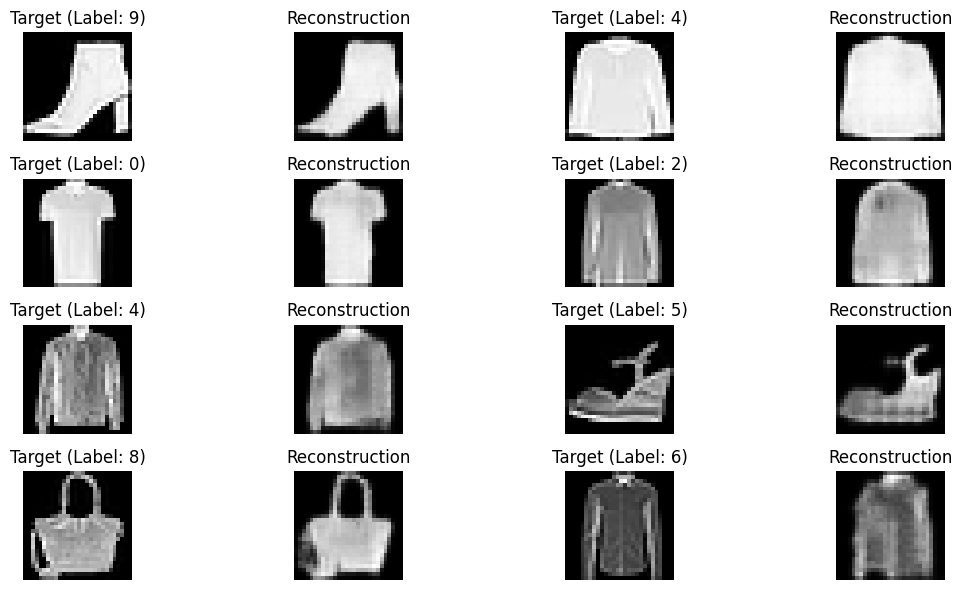

In [49]:
# Example usage (assuming your model and test_loader are defined)
plot_target_reconstruction(vqvae, test_loader, k=8)

In [50]:
vqvae.save_model("vqvae_10e.pth")

Saved model to vqvae_10e.pth
